In [1]:
from pystac_client import Client
import fsspec
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd 
import requests
from IPython.display import Image, display
import os 
import pathlib
from tqdm import tqdm

from scipy import stats  # will use scipy.stats.mode as the reducer
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs


In [2]:
def cluster_variance(n, x):
    variances=[]
    kmeans=[]
    outputs=[]
    K=[i for i in range(1,n+1)]
    for i in range(1,n+1):
        variance=0
        model=KMeans(n_clusters=i,random_state=82,verbose=2).fit(x)
        kmeans.append(model)
        variances.append(model.inertia_)
    return variances,K,n

In [3]:
ds = xr.open_dataset(f"challenge_1min_complete.nc")
ds

sh: 1: getfattr: not found


<xarray.Dataset> Size: 325kB
Dimensions:                          (time: 3012)
Coordinates:
  * time                             (time) datetime64[ns] 24kB 2025-06-12T06...
Data variables: (12/14)
    latitude                         (time) float64 24kB ...
    longitude                        (time) float64 24kB ...
    land_flag                        (time) float64 24kB ...
    ice_water_path                   (time) float32 12kB ...
    liquid_water_path                (time) float32 12kB ...
    aerosol_optical_thickness_355nm  (time) float32 12kB ...
    ...                               ...
    stc_7500                         (time) float64 24kB ...
    stc_10000                        (time) float64 24kB ...
    stc_12500                        (time) float64 24kB ...
    stc_15000                        (time) float64 24kB ...
    stc_17500                        (time) float64 24kB ...
    stc_20000                        (time) float64 24kB ...

In [9]:
ds['stc_2500'].head(50)

<xarray.DataArray 'stc_2500' (time: 50)> Size: 400B
array([-1., 11., 11., 11.,  7., 29., 29.,  7., 29.,  7.,  1., 27., 11., -1.,
        7.,  7., 27., 27., 27., 27., 27., 27., 27., 27.,  1., 29., 29.,  1.,
        1.,  1., 27.,  7., 29., 11.,  5.,  7.,  1., 27., 29., -1., 27., 27.,
       27., 27., 28., 29., 29., 29.,  7., 11.])
Coordinates:
  * time     (time) datetime64[ns] 400B 2025-06-12T06:53:00 ... 2025-06-12T18...

In [10]:
# x = ds.drop_vars(['latitude','longitude']).to_array().transpose("time", "variable").values
x = ds.to_array().transpose("time", "variable").values
x

array([[ 22.89030849, 108.70155789,   0.26666667, ...,  -1.        ,
         -1.        ,  -1.        ],
       [ 20.46667147, 108.2025121 ,   0.21428571, ...,   1.        ,
          1.        ,   1.        ],
       [ 16.58567532, 107.42342977,   0.53095238, ...,  21.        ,
         21.        ,   1.        ],
       ...,
       [ 17.28022211, 116.75413216,   0.        , ...,  21.        ,
          1.        ,   1.        ],
       [ 21.15949019, 115.97022507,   0.        , ...,   1.        ,
          1.        ,   1.        ],
       [ 23.25445562, 115.5362402 ,   0.        , ...,  -1.        ,
         -1.        ,  -1.        ]], shape=(3012, 14))

Initialization complete
Iteration 0, inertia 5510317.932709193.
Iteration 1, inertia 3659347.930380368.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4456860.236169905.
Iteration 1, inertia 3151645.7430660203.
Iteration 2, inertia 3008693.868864397.
Iteration 3, inertia 2922479.320513778.
Iteration 4, inertia 2873080.5629490777.
Iteration 5, inertia 2843644.559185786.
Iteration 6, inertia 2832024.426446344.
Iteration 7, inertia 2827991.838136547.
Iteration 8, inertia 2825160.019591644.
Iteration 9, inertia 2824255.03852767.
Iteration 10, inertia 2823849.3264666516.
Iteration 11, inertia 2823622.7752858247.
Iteration 12, inertia 2823471.0273885746.
Iteration 13, inertia 2823400.264126529.
Converged at iteration 13: center shift 0.002620900801995979 within tolerance 0.00867802108323931.
Initialization complete
Iteration 0, inertia 4061871.866325316.
Iteration 1, inertia 2648601.1188686364.
Iteration 2, inertia 2302414.065889619.
Iteration 3, i

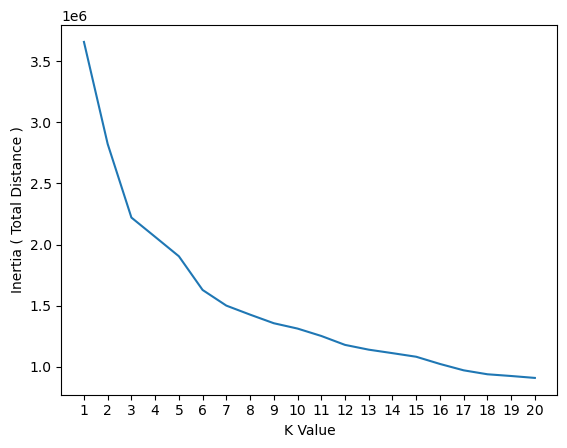

In [11]:
variances,K,n=cluster_variance(20, x)
plt.plot(K,variances)
plt.ylabel("Inertia ( Total Distance )")
plt.xlabel("K Value")
plt.xticks([i for i in range(1,n+1)])
plt.show()

In [12]:
vars = {
    'lat': 0,
    'lon': 1,
    'landf': 2,
    'iwp': 3,
    'lwp': 4,
    'aot': 5,
    'stc25': 6,
    'stc50': 7,
    'stc75': 8,
    'stc100': 9,
    'stc125': 10,
    'stc150': 11,
    'stc175': 12,
    'stc200': 13
}

In [13]:
def plot_kmeans(x, varX, varY):
    
    # Visualizziamo i dati colorati in base ai cluster trovati
    plt.figure(figsize=(8, 6))
    plt.scatter(x[:, vars[varX]], x[:, vars[varY]], c=y_kmeans, s=20, cmap='viridis')
    
    # Mostriamo anche i centroidi
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, vars[varX]], centers[:,  vars[varY]], c='red', s=50, alpha=0.75, marker='X', label='Centroids')
    
    plt.title("K-Means clustering")
    plt.xlabel(varX)
    plt.ylabel(varY)
    plt.legend()
    plt.show()

In [17]:
# Applichiamo K-Means
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
y_kmeans = kmeans.fit_predict(x)


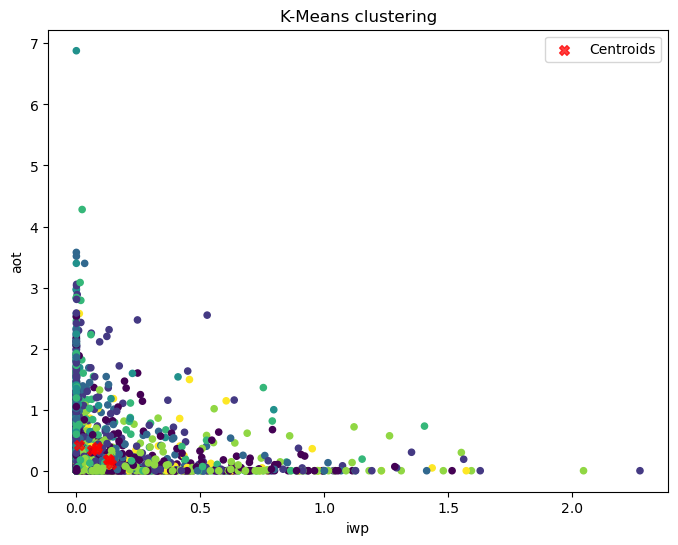

In [18]:
varX='iwp'
varY='aot'

plot_kmeans(x, varX, varY)

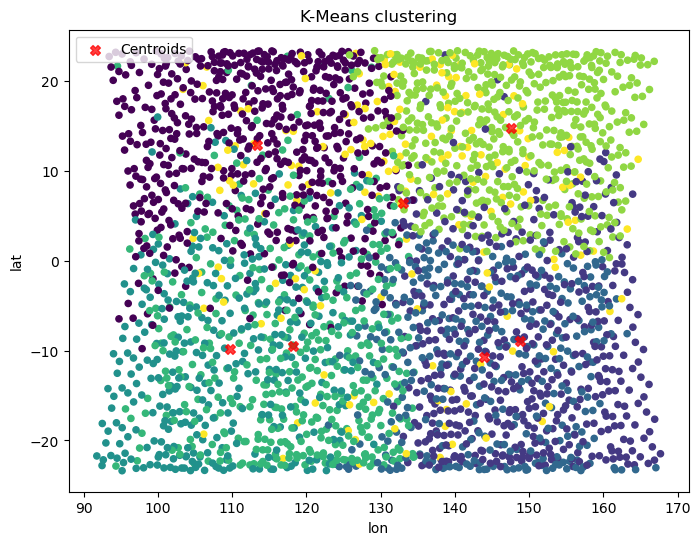

In [19]:
varX='lon'
varY='lat'

plot_kmeans(x, varX, varY)

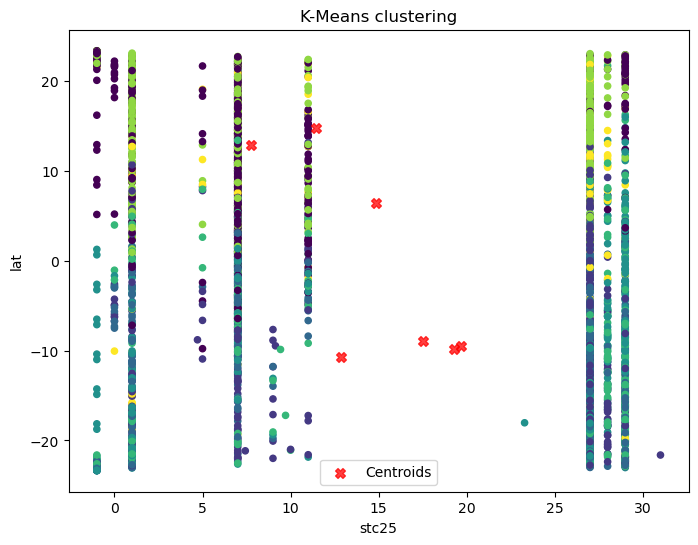

In [20]:
varX='stc25'
varY='lat'

plot_kmeans(x, varX, varY)